In [27]:
import pprint
import matplotlib.pyplot as plt
# import psycopg2 as pg2
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster, HeatMap


plt.style.use('ggplot')
%matplotlib inline

In [2]:
# from pymongo import MongoClient

# client = MongoClient()

# db = client['bars_and_crime']
# bars = db['bars']

# def mongo_to_dict(doc):
#     d = {}
#     val = doc['_id']
#     for k, v in val.items():
#         if type(v) is dict:
#             for k2, v2 in v.items():
#                 if type(v2) is dict:
#                     for k3, v3 in v2.items():
#                         d[k3] = v3
#                 elif type(v2) is not list:
#                     d[k2] = v2
#         else:
#             d[k] = v
#     return d


# result = bars.aggregate( 
#                 [{"$group": 
#                       { "_id": {"id": "$id", "alias": "$alias", "name": "$name",
#                                 "review_count": "$review_count", "rating": "$rating",
#                                 "coordinates": "$coordinates", "location": "$location"}}}]
#         )

# for item in result:
#     py_dict = mongo_to_dict(item)
#     with open('bar_data.csv', 'a') as f:
#         vs = '\t'.join(str(x) for x in py_dict.values())
#         f.write(f'{vs}\n')

In [3]:
brs = pd.read_csv('bar_data.csv', 
                 sep='\t', 
                 names=['id', 'alias', 'name', 'review_count', 'rating', 
                        'lat', 'lng', 'addr1', 'addr2', 'addr3', 'city', 
                        'zip', 'country', 'state']).drop_duplicates(subset='alias')

crm = pd.read_csv('police_data.csv', 
                 names=['incident','offense_descr','offense_code',
                'fam_violence','occurred_date_time','occurred_date','occurred_time',
                'report_date_time','report_date','report_time','location_type',
                'address','zip','district','apd_sector','apd_district','pra',
                'census_tract','clearance_status','clearance_date','ucr_category',
                'category_descr','x_coord','y_coord','lat','lng','location'])

/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
brs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797 entries, 0 to 798
Data columns (total 14 columns):
id              797 non-null object
alias           797 non-null object
name            797 non-null object
review_count    797 non-null int64
rating          797 non-null float64
lat             797 non-null float64
lng             797 non-null float64
addr1           795 non-null object
addr2           340 non-null object
addr3           195 non-null object
city            797 non-null object
zip             795 non-null float64
country         797 non-null object
state           797 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 93.4+ KB


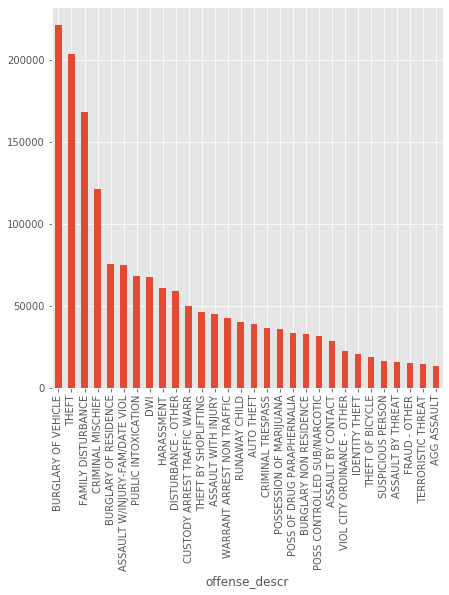

In [4]:
off_desc = crm[['offense_descr', 'fam_violence']].groupby('offense_descr')\
            .count().sort_values('fam_violence', ascending=False).rename(columns={'fam_violence': 'count'})
plot = off_desc.iloc[:30].plot.bar(y='count', figsize=(7,7), legend=False)

In [17]:
# print(br[['incident','occurred_date']].max())
# print(br[['incident','occurred_date']].min())

pub_int = crm[crm['offense_descr'] == 'PUBLIC INTOXICATION']
pub_int = pub_int[~pub_int['lat'].isnull()]
print(pub_int['lat'].count())
print(pub_int['lat'].min())
print(pub_int['lat'].max())

print(pub_int['lng'].min())
print(pub_int['lng'].max())

67324
4.12303067
30.59887309
-99.15499766
-97.36795504


In [6]:
map_df = pub_int[['occurred_date', 'lat', 'lng']]
sub_setmap = map_df[:10000]
austin_map = folium.Map(location=['30.264980', '-97.746597'], zoom_start=11)

HeatMap(data=sub_setmap[['lat', 'lng']].values.tolist(), radius=8, max_zoom=13).add_to(austin_map)

austin_map

In [7]:
# pick a few points to iterate through city of Austin first
# or alternately, skip this step 

# look at folium for a Map visualization

## Tomas' folium example

In [8]:
# map_df = mod_df[['cost','source','lat','lon']]
# # sub_setmap = map_df.query("source == 'reator'")
# sub_setmap = map_df[:2000]
# austin_map = folium.Map(location=['30.264980', '-97.746597'], zoom_start =10)

# mc = MarkerCluster()

# for row in sub_setmap.itertuples():
#     mc.add_child(folium.Marker(location=[row.lat,row.lon], popup=[row.cost]))

In [9]:
def bars_in_box(upper, lower, left, right, df):
    results = df[(df['lat'] > lower) & (df['lat'] <= upper) & (df['lng'] > left) & (df['lng'] <= right)]
    
    return results['lat'].count()

0.29541595925297115
348
325


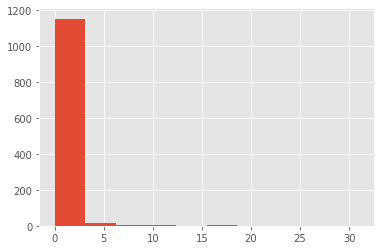

In [33]:
# LAT IS Y
# LNG IS X

def get_bars_from_grid(df, tl, tr, bl, br, step=.002):
    topleft_lat = tl[0]
    topleft_lng = tl[1]
#     box_cnt = 0
    bars_in_range = []
    
    while topleft_lat + step > bl[0]:
        if topleft_lng + step > tr[1]:
            topleft_lng = tl[1]
            topleft_lat -= step
        while topleft_lng + step < tr[1]:
            bars_in_range.append(bars_in_box(topleft_lat, topleft_lat - step, topleft_lng, topleft_lng + step, df))
#             box_cnt += 1
            topleft_lng += step
    
#     if box_cnt >= 31*20:
#         break
    return bars_in_range


tl = 30.3335, -97.7707
tr = 30.3335, -97.7077
bl =  30.2631, -97.7707
br = 30.2631, -97.7077
bir = get_bars_from_grid(brs[['lat','lng']], tl, tr, bl, br)
print(np.mean(bir))
print(np.sum(bir))


# print(bars_in_box(tl[0], tl[0]-20*step, tl[1], tr[1], brs[['lat','lng']]))
# print(bars_in_box(tl[0], bl[0], tl[1], tr[1], brs[['lat','lng']]))# gets all bars in area
print(bars_in_box(tl[0], bl[0]-.002, tl[1], tr[1]+.002, brs[['lat','lng']]))# gets all bars in area + padding


fig, ax = plt.subplots()
plot = ax.hist(bir)


# Note: Passing through the whole region as one yields 289 bars
# while iterating yields 348. Why is this?
#     Could be double counting
#     Could be grabbing bars on the edge, past the map.
#         Can't be double counting because going .002 outside the
#         right and bottom yields 325 total.

In [18]:
pub_int = pub_int[['offense_descr','occurred_date','report_date',
                   'category_descr','lat','lng']]
pub_int['occurred_date'] = pd.to_datetime(pub_int['occurred_date'])
pub_int['year'] = pub_int['occurred_date'].dt.year
pub_int = pub_int[pub_int['year'] >= 2015]
# pub_int.count()

offense_descr     9706
occurred_date     9706
report_date       9706
category_descr       0
lat               9706
lng               9706
year              9706
dtype: int64

In [24]:
def get_bars_from_crimes(df, step=.002):
    pass

df1 = brs.loc[:,('lat','lng')]
df2 = pub_int.loc[:,('lat','lng')]

step = .002
bars_in_range = []
for index, row in df2.iterrows():
    if row['lat'] <= tl[0] and row['lat'] > br[0] and row['lng'] >= tl[1] and row['lng'] < br[1]:
        bars = bars_in_box(row['lat'] + step/2, row['lat'] - step/2, row['lng'] - step/2, row['lng'] + step/2, df1)
        bars_in_range.append(bars)
# df3 = df1.merge(df2, how='outer')
# df3.info()

13.965004133370075


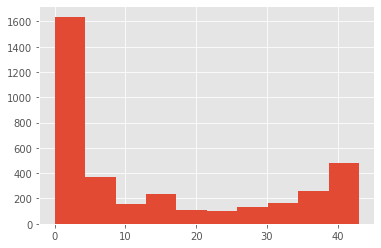

In [28]:
fig, ax = plt.subplots()
plot = ax.hist(bars_in_range)

print(np.mean(bars_in_range))